# Impact of Covid-19 on air pollution in northern India

## Background
22 of the 30 most polluted cities in the world (based on PM2.5 concentrations) are in India, and all 22 of these lie in the northern Indian states of Delhi, Uttar Pradesh or Haryana ([IQ Air 2020](https://www.iqair.com/world-most-polluted-cities)). Significant contributions to this poor air quality are attributed to burning of biomass, including crop residue and household fuels - upto 20 per cent of PM2.5 in Delhi in 2019 was contributed by this source, according to [UrbanEmissions.com](https://urbanemissions.info/blog-pieces/whats-polluting-delhis-air/). Nearby states, particularly Haryana and Punjab, also contribute to the poor air quality in the region due to the practice of burning of crop residue that is prevelant in these states.

The aim of this notebook is to investigate the impact of the Covid-19 pandemic and the societal responses it triggered on the air quality of the northern India region, focussing on the air pollution caused by crop residue burning in Punjab and Haryana. 

For the purpose of this study, we consider the area bounded by the box (73.809761 E, 28.644667 N, 81.019043 E, 32.562569 N). We consider data from the years 2018 and 2019 to establish 'baseline' conditions in terms of air quality and fire incidences, and compare with 2020 when Covid-19 and the lockdowns took effect. The datasets and methods used are described in more detail below.

### Load shapefile containing state boundaries of India

In [3]:
import geopandas as gpd
states = gpd.read_file('zip://../data/india_states_highres_jk-separate.zip')

## Air quality data
Air quality data is obtained from the CPCB's [Central Control Room for Air Quality Management](https://app.cpcbccr.com/ccr/#/caaqm-dashboard-all/caaqm-landing/caaqm-comparison-data). We consider data from 8 different Central Pollution Control Board (CPCB) monitoring stations within our study region, and obtain data for 2018-2021 via the CPCB portal.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.data.utils import baseline

In [5]:
df = pd.read_excel('../data/cpcb-aq.xlsx', skiprows=12).replace('None', np.nan)
df = df.drop(columns='To Date').rename(columns={'From Date': 'time'})
df = df.iloc[:, np.r_[0, 2, 6:9]]
df['time'] = df['time'].astype('datetime64[ns]')

In [6]:
# Manually enter coordinate of the 4 CPCB stations, taken from CPCB website
coordinates = [[29.695300,  77.002700] ,
               [31.321907 , 75.578914],
               [29.140560, 75.744941],
               [30.349388 , 76.366642]]

In [7]:
stations = gpd.GeoDataFrame(coordinates)
stations.geometry = gpd.points_from_xy(stations[1], stations[0])
stations.index = df.columns[1:]
stations

,0,1,geometry
Sector-12 Karnal - HSPCB,29.695300,77.002700,POINT (77.00270 29.69530)
Civil Line Jalandhar - PPCB,31.321907,75.578914,POINT (75.57891 31.32191)
Urban Estate-II Hisar - HSPCB,29.140560,75.744941,POINT (75.74494 29.14056)
Model Town Patiala - PPCB,30.349388,76.366642,POINT (76.36664 30.34939)


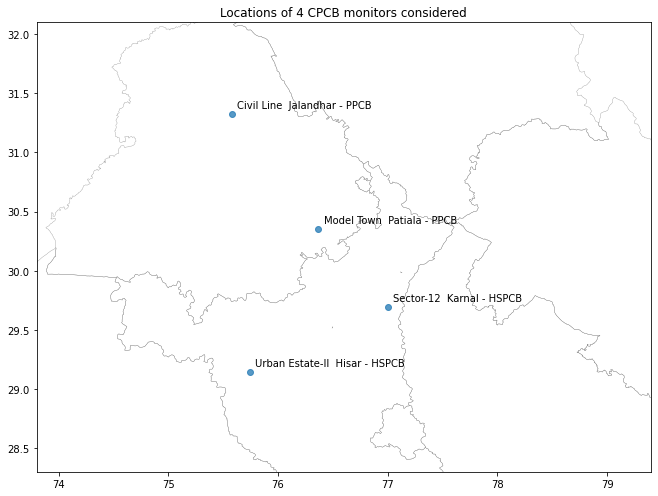

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
stations.plot(ax=ax, markersize=36, alpha=0.75)
ax.set_xlim(73.8, 79.4)
ax.set_ylim(28.3, 32.1)
states.plot(ax=ax, fc='None', ec='grey', lw=0.3)

for index, row in stations.iterrows():
    ax.annotate(index, xy=(row[1]+0.05, row[0]+0.05))
    
plt.title('Locations of 4 CPCB monitors considered')
plt.tight_layout()

In [12]:
import warnings; warnings.filterwarnings("ignore", category=UserWarning)

In [13]:
aq_baseline = baseline(df, agg='mean', date_col='time')
aq_baseline.head()

C:\Users\vidurmithal\Work\BSA\env\lib\site-packages\pandas\core\frame.py:9134: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


current                               \
           Sector-12  Karnal - HSPCB Civil Line  Jalandhar - PPCB   
2020-01-01                       NaN                          NaN   
2020-01-02                    153.01                       109.01   
2020-01-03                     72.15                        70.48   
2020-01-04                     30.73                        41.22   
2020-01-05                     26.87                        16.71   

                                                                      \
           Urban Estate-II  Hisar - HSPCB Model Town  Patiala - PPCB   
2020-01-01                            NaN                        NaN   
2020-01-02                         141.38                      73.65   
2020-01-03                          80.18                      42.64   
2020-01-04                          43.93                      14.37   
2020-01-05                          25.96                      10.52   

                            baseline                               \
           Sector-12  Karnal - HSPCB Civil Line  Jalandhar - PPCB   
2020-01-01                       NaN                          NaN   
2020-01-02                       NaN                        77.52   
2020-01-03                     91.54                        66.63   
2020-01-04                     54.01                        59.97   
2020-01-05                     46.09                        39.89   

                                                                      
           Urban Estate-II  Hisar - HSPCB Model Town  Patiala - PPCB  
2020-01-01                            NaN                        NaN  
2020-01-02                            NaN                     44.440  
2020-01-03                          94.38                     27.160  
2020-01-04                          69.08                     25.420  
2020-01-05                          43.66                     39.675

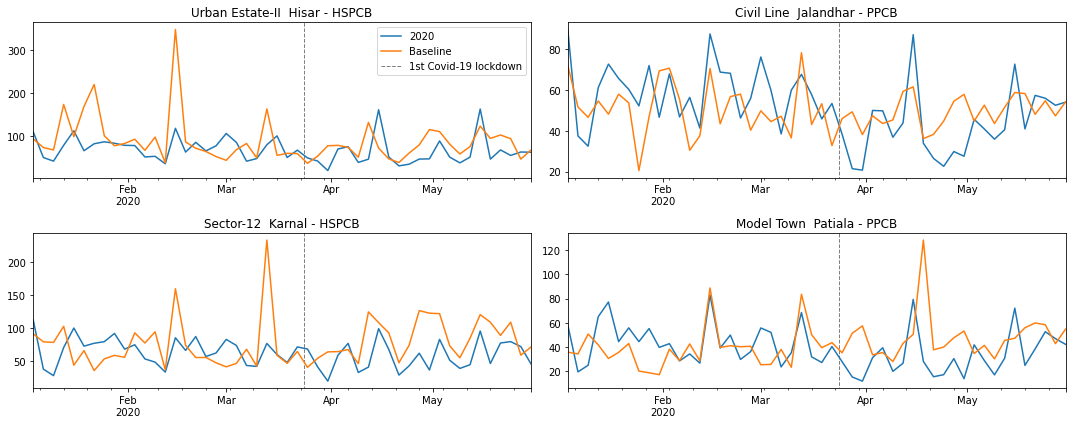

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15,6))
for index, station in enumerate(list(set(aq_baseline.columns.get_level_values(1)))):
    
    ax = axs.flatten()[index]
    
    toPlot = aq_baseline.resample('3D', label='right').mean().loc[:, aq_baseline.columns.get_level_values(1) == station]
    toPlot.columns = ['2020', 'Baseline']
    
    toPlot.iloc[:50,:].plot(ax=ax, legend=False)    
    
    ylim = ax.get_ylim()

    ax.vlines(x=pd.to_datetime('2020-03-24'), ymin=0, ymax=500, lw=1, zorder=-1, 
              color='grey', linestyle='--', label='1st Covid-19 lockdown')
    
    ax.set_ylim(ylim)
    ax.set_title('%s'%station)
    
    if index==0:
        ax.legend()
        
plt.tight_layout()

The figure above shows the difference in PM2.5 concentration between the baseline, calculated using 2018 and 2019 data, and 2020, when Covid-induced lockdowns occured. There is a reduction in PM2.5 concentrations in the days following March 24, which is when the first nationwide lockdown was announced. The figure below highlights that all eight stations witnessed significant reductions in PM2.5 concentrations in the two-month period following the first lockdown. On average, there was a roughly **20 per cent reduction** in PM2.5 concentrations across these 8 monitors in the post-lockdown period in 2020 compared with baseline values.

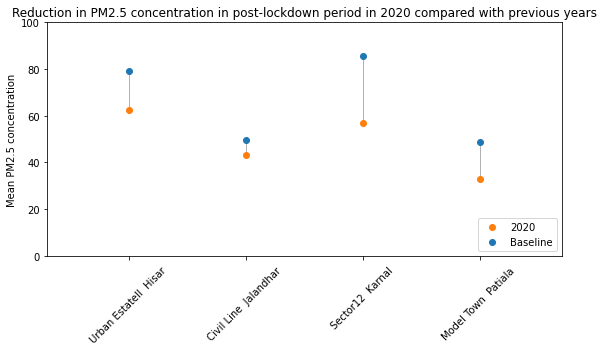

In [19]:
fig, ax = plt.subplots(1, figsize=(8,5))

for index, station in enumerate(list(set(aq_baseline.columns.get_level_values(1)))):
    
    label = ''.join(station.split('-')[:-1])
    toPlot = aq_baseline.loc[:, aq_baseline.columns.get_level_values(1) == station]
    toPlot.columns = ['2020', 'Baseline']
    
    postcovid = (toPlot[(toPlot.index >  pd.to_datetime('2020-03-24')) & 
                       (toPlot.index <  pd.to_datetime('2020-05-30'))]
                 .mean().values)

    ax.scatter(['%s'%label], [postcovid[0]], c='C1', label='2020')
    ax.scatter(['%s'%label], [postcovid[1]], c='C0', label='Baseline')
    
    ax.set_xlim(-0.7, 3.7)
    ax.set_ylim(0, 100)

    ax.vlines(x=label , ymin=postcovid[0], ymax=postcovid[1], zorder=-1, color='grey', lw=0.6)
    
    if index==0:
        ax.legend(loc='lower right')
    
plt.ylabel('Mean PM2.5 concentration')
plt.title('Reduction in PM2.5 concentration in post-lockdown period in 2020 compared with previous years')
plt.xticks(rotation=45)
plt.tight_layout()

## Fire data
Fire data is obtained from NASA's [Fire Information for Resource Management System (FIRMS)](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms) database. We use the fire data collected by the VIIRS instrument aboard the Suomi NPP satellite. The VIIRS has a spatial resolution of 375m and produced two measurements per day globally. Pixels are identified as active fires based on their radiant intensity, and the database provides information on the confidence, brightness and radiative power of each detected event. For the purpose of our analysis, we make use of only 'high' confidence detections. 

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.data.utils import baseline

In [21]:
fires = gpd.read_file('../data/DL_FIRE_SV-C2_215232/fire_archive_SV-C2_215232.shp')

# Converting date column to pandas datetime format
fires['ACQ_DATE'] = fires['ACQ_DATE'].astype('datetime64[ns]')

# Selecting only 'high' confidence retrievals
fires = fires[fires.CONFIDENCE=='h']
fires.head(2)

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
223,29.239923,75.688538,367.0,0.49,0.65,2018-01-05,0712,N,VIIRS,h,1,290.17,17.30,D,0,POINT (75.68854 29.23992)
227,29.235071,75.688828,367.0,0.49,0.65,2018-01-05,0712,N,VIIRS,h,1,292.71,12.16,D,0,POINT (75.68883 29.23507)


**2020 saw a significantly smaller number of fires detected by satellite compared to previous years**. The difference is evident across all states, including Punjab, Haryana, Uttarakhand, and Uttar Pradesh. The figure below highlights this trend.

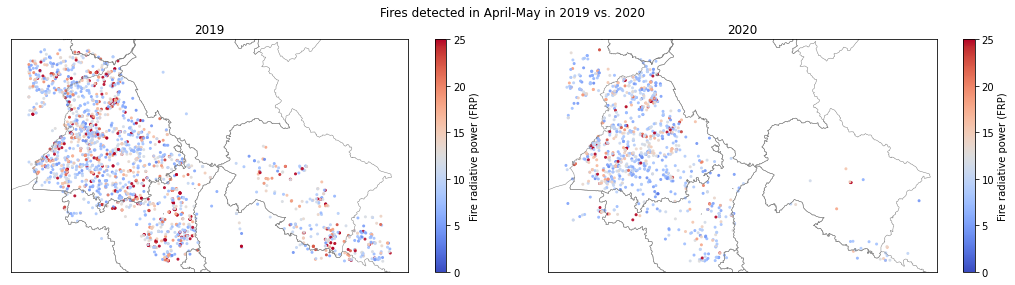

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

for i in range(2):
    year = 2019+i
    
    fires_ = fires[fires.ACQ_DATE.dt.year == year]
    
    fires_ = fires_[fires_.ACQ_DATE.dt.month.isin([4,5])]

    fires_.plot(ax=ax[i], markersize=4, alpha=0.85, column='FRP', cmap='coolwarm',  
                vmin=0, vmax=25, legend=True, legend_kwds=dict(label='Fire radiative power (FRP)'))
    
    xlim, ylim = ax[i].get_xlim(), ax[i].get_ylim()
    
    states.plot(ax=ax[i], fc='None', ec='grey', lw=0.5)
    
    ax[i].set_xlim(xlim), ax[i].set_ylim(ylim)
    ax[i].set_xticks([]), ax[i].set_yticks([])
    ax[i].set_title('%s'%year)
    
plt.suptitle('Fires detected in April-May in 2019 vs. 2020')
plt.tight_layout()

C:\Users\vidurmithal\Work\BSA\env\lib\site-packages\pandas\core\frame.py:9134: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


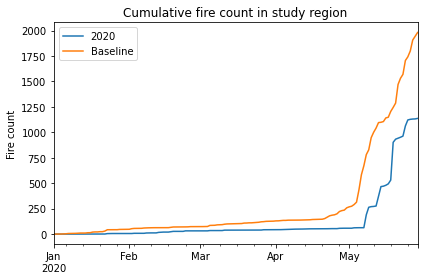

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
f = baseline(fires, agg='count').fillna(0)
f = f.loc[:, f.columns.get_level_values(1)=='LATITUDE']
f.columns = ['2020', 'Baseline']
f.cumsum().iloc[:150].plot(ax=ax)

ax.set_title('Cumulative fire count in study region')
ax.set_ylabel('Fire count')
plt.tight_layout()

## Analysing impact of fire events on air quality
For each of the four considered CPCB stations, we investigate the relationship between satellite-observed fires and air quality. We define buffer regions around the stations, and attempt to correlate the number of fires detected in that buffer region to the air quality observed at the monitor. We find that for three of the four stations there is a positive correlation of <b>$R \approx 0.15$</b>.

In [27]:
from scipy.stats import pearsonr

In [28]:
print('Correlation coef between fire count in 0.5 degree buffer around AQ monitoring station and PM2.5 concentration at station...\n')

for index, station in enumerate(stations.index.values):

    aq = df.set_index('time')[station]
    aq_fire = gpd.sjoin(fires, stations.set_geometry(stations.buffer(0.5)).iloc[index:index+1], op='within').set_index('ACQ_DATE')
    
    joined = aq_fire.groupby(aq_fire.index).count().join(aq)
    joined = joined.iloc[:,np.r_[-1, joined.columns.get_loc('FRP')]].dropna()
    
    print('for %32s: %.3f'%(station, pearsonr(joined['FRP'], joined.iloc[:,-2])[0]))

Correlation coef between fire count in 0.5 degree buffer around AQ monitoring station and PM2.5 concentration at station...

for        Sector-12  Karnal - HSPCB: 0.169
for     Civil Line  Jalandhar - PPCB: 0.134
for   Urban Estate-II  Hisar - HSPCB: -0.119
for       Model Town  Patiala - PPCB: 0.178


## ERA5 data
To improve this simplistic model, we also consider meteorological data from the ERA5 reanalysis dataset to account for meteorological influence on PM2.5 concentrations. ERA5 data is obtained from the [Copenicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form).

For each of the four stations, we find the closest point represented in the ERA5 data (of grid size 0.25 by 0.25 degrees, i.e. roughly 30 km by 30 km). We extract the time series of meteorological data at that point and join it with the air quality and fire count data we had computed previously. This dataframe is then used to run a simple linear regression with PM2.5 concentration taken as the dependent variable and the fire count and 4 meteorological variables taken as the independent variables.

In [29]:
import xarray as xr

In [30]:
era5 = xr.open_dataset('../data/adaptor.mars.internal-1629049903.0737226-28705-8-2d911292-bd6b-425c-a744-dbbc476c8775.nc')
era5

<xarray.Dataset>
Dimensions:    (longitude: 17, latitude: 15, time: 6624)
Coordinates:
  * longitude  (longitude) float32 74.5 74.75 75.0 75.25 ... 78.0 78.25 78.5
  * latitude   (latitude) float32 32.0 31.75 31.5 31.25 ... 29.0 28.75 28.5
  * time       (time) datetime64[ns] 2018-03-01 ... 2020-05-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-15 17:52:55 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

## Statistical model
A simple regression model is constructed using the PM2.5 concentrations as the dependent variable and the meteorological variables and the fire counts as the independent variables. An example of the model results for the Hisar station is shown.

In [42]:
station_dfs = []

for index, row in stations.reset_index().rename(columns={'index':'station'}).iterrows():

    x = row[1]
    y = row[0]
    
    # Join fire counts with AQ data
    aq = df.set_index('time')[row.station]
    aq_fire = gpd.sjoin(fires, stations.set_geometry(stations.buffer(0.5)).iloc[index:index+1], op='within').set_index('ACQ_DATE')
    joined = aq_fire.groupby(aq_fire.index).count().join(aq)
    joined = joined.iloc[:,np.r_[-1, joined.columns.get_loc('FRP')]].dropna()
    joined.columns = ['PM25', 'fires']
    
    # Join ERA5 data from nearest grid cell to AQ and fire data
    era5_df = (era5.sel(longitude=x, latitude=y, method='nearest')
               .to_dataframe()
               [['u10','v10','t2m','tp']]
              )
    era5_df['windspeed'] = np.sqrt(era5_df['u10']**2 + era5_df['v10']**2)
#     era5_df = era5_df.drop(columns=['v10', 'u10'])
    
    joined = joined.join(era5_df)
  
    station_dfs.append(joined)

In [43]:
import statsmodels.api as sm

In [44]:
toModel = station_dfs[2]
toModel.iloc[:,1] = toModel.iloc[:,1].shift(-1)
toModel = toModel[toModel.index.year==2019].dropna()

In [45]:
model = sm.OLS(toModel.iloc[:,0], toModel.iloc[:,1:] )

In [46]:
res = model.fit()

In [47]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PM25   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     1.853
Date:                Mon, 16 Aug 2021   Prob (F-statistic):              0.324
Time:                        02:00:35   Log-Likelihood:                -35.602
No. Observations:                   9   AIC:                             83.20
Df Residuals:                       3   BIC:                             84.39
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
fires          0.8972      3.168      0.283      0.795      -9.185      10.979
u10           -8.4810      6.639     -1.278      0.291     -29.609      12.646
v10            5.9515      7.097      0.839      0.463     -16.634      28.537
t2m           -8.5005      4.499     -1.890      0.155     -22.817       5.816
tp          5.601e+12   2.88e+12      1.941      0.148   -3.58e+12    1.48e+13
windspeed     11.4522     12.987      0.882      0.443     -29.880      52.784
==============================================================================
Omnibus:                        1.613   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.446   Jarque-Bera (JB):                1.038
Skew:                          -0.604   Prob(JB):                        0.595
Kurtosis:                       1.857   Cond. No.                     1.18e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.76e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

___